<a href="https://colab.research.google.com/github/johnlocke333/xray_image_classification/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preparation**


In [1]:
#My environment required me to install certain packages and versions. Please check your environment to see if this is needed.
#If you need to do so then please uncomment the below code.

#!pip install scikeras
#!pip install scikit-learn==1.2.2
#!pip install lime
#!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires scikit-learn>=1.4.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7f2418845b2b12909f5345d9ecb65d2d5f35c0cc3be7688a3ee

In [1]:
#Import the necessary libraries for image manipulation, graphing, preprocessing, modeling, metrics, and explainability. The imports are divided into sections in the order
#that they were initiated in the notebook.
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython import get_ipython
from IPython.display import display

import lime
from lime import lime_image
from skimage.io import imread
from skimage.segmentation import mark_boundaries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [4]:
#load the dataset in from kaggle, uncomment the below code to download the data.

#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [5]:
#unzip the dataset so it can be loaded into the notebook. Uncomment the below line in order to do so. I am commenting it out so it does not consume most of the notebook.

#!unzip chest-xray-pneumonia.zip

In [2]:
# Directory path
train_data_dir = 'chest_xray/train'
test_data_dir = 'chest_xray/test'
valid_data_dir = 'chest_xray/val'

In [3]:
# Get all the data from the directory, and reshape them to put into their datasets. Putting into function for reusability for train,test,valid.
def get_reshape_images(dir, bs):
  '''
  The function will take in the directory path (dir) for the image as well as the batch size (bs). It will reshape the image to (128,128) and assign the images to (images)
  and the labels to (labels).
  '''
  generator = ImageDataGenerator().flow_from_directory(
          dir, target_size=(128, 128), batch_size=bs)

  images, labels = next(generator)
  return images, labels

In [7]:
#Using our function to reshape images and assign the train images and labels from the directory path.
train_images, train_labels = get_reshape_images(train_data_dir, 5216)

Found 5216 images belonging to 2 classes.


In [8]:
#Using our function to reshape images and assign the test images and labels from the directory path.
test_images, test_labels = get_reshape_images(test_data_dir, 624)

Found 624 images belonging to 2 classes.


In [9]:
#Using our function to reshape images and assign the valid images and labels from the directory path.
valid_images, valid_labels = get_reshape_images(valid_data_dir, 16)

Found 16 images belonging to 2 classes.


In [10]:
 #Need to manipulate the dimensions of the images and labels so they can be passed into the model. For example, I want the images to be (5216,49152) and the labels to be
#(5216,1) for the training dataset.
 def reshape_input_image_label(images, m, labels):
  '''
  Will take in the image dataset (images) and reshape them to the desired outcome by using the amount of images (m) to get the required dimension for the model.
  It will also take in the label dataset (labels) and reshape them to the desired dimension needed for the model.
  '''
  img_unrow = images.reshape(m, -1)
  labels_final = labels.T[[1]].T
  return img_unrow, labels_final

In [11]:
#Using our function to change dimensions of the train images and labels, with the total number of images in the dataset.
train_img_unrow, train_label_final = reshape_input_image_label(train_images, 5216, train_labels)

In [12]:
#Using our function to change dimensions of the test images and labels, with the total number of images in the dataset.
test_img_unrow, test_label_final = reshape_input_image_label(test_images, 624, test_labels)

In [13]:
#Using our function to change dimensions of the valid images and labels, with the total number of images in the dataset.
valid_img_unrow, valid_label_final = reshape_input_image_label(valid_images, 16, valid_labels)

In [14]:
#I want to standardize the images for better efficiency and results. Helps reduce data complexity. Currently between 0 and 255 but want it to be between 0 and 1.
def standardize(img_unrow):
  '''
  Takes in the image dataset (img_unrow) and standardizes it.
  '''
  img_final = img_unrow/255
  return img_final

In [15]:
#Standardize the train images.
train_img_final = standardize(train_img_unrow)

In [16]:
#Standardize the test images.
test_img_final= standardize(test_img_unrow)

In [17]:
#Standardize the valid images.
valid_img_final = standardize(valid_img_unrow)

In [18]:
#Currently, the dataset has class imbalance in favor of pneumonia. To fix this I need to adjust the class weights. This will be implemented during model.fit().
class_weights_train = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_label_final),
                                     y=train_label_final.ravel())

#Convert to dictionary format so it can be passed into the model.fit.
class_weights_dict_train = {0: class_weights_train[0], 1: class_weights_train[1]}

# **Model**

In [19]:
#Building baseline model. Passing into function so it can be used in gridsearch later.
def build_baseline(optimizer='SGD', activation='relu',neurons=2):
  baseline_model = models.Sequential()
  baseline_model.add(layers.Dense(neurons, activation=activation, input_shape=(49152,)))
  baseline_model.add(layers.Dense(1, activation='sigmoid'))
  baseline_model.compile(optimizer=optimizer,
                        loss='binary_crossentropy',
                        metrics=['recall'])
  return baseline_model


In [20]:
#Fitting baseline model to see the results.
baseline_model = build_baseline()
baseline_model.fit(train_img_final,
                    train_label_final,
                    epochs=6,
                    batch_size=3,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.8001 - recall: 0.4490 - val_loss: 0.6910 - val_recall: 1.0000
Epoch 2/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6987 - recall: 0.5845 - val_loss: 0.7018 - val_recall: 0.0000e+00
Epoch 3/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6909 - recall: 0.2558 - val_loss: 0.6958 - val_recall: 0.0000e+00
Epoch 4/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.6883 - recall: 0.5097 - val_loss: 0.6898 - val_recall: 1.0000
Epoch 5/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.6911 - recall: 0.7657 - val_loss: 0.6999 - val_recall: 0.0000e+00
Epoch 6/6
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.6852 - recall: 0.4687 - val_loss: 0.6938 - val_recall: 0.0000e+00


In [21]:
#Apply early stoppage so the model reduces on the time spent running each epoch. Makes for better efficiency and reduce computation cost/time.
early_stopping = [EarlyStopping(monitor='val_loss', patience=10)]

In [22]:
#Wrap the model in KerasClassifier so it can be used for the gridsearch.
tuning_model=KerasClassifier(build_fn=build_baseline)

In [23]:
#Create the grid to see what parameters work best for the model. The gridsearch can take a long time to run so I have removed certain factors I used when finding the
#best parameters so if you run the gridsearch it will save you some time.
param_grid = {
    "model__neurons": [20], #[10,20,30]
    "model__optimizer": ['SGD'], #['adam', 'RMSProp']
    "model__activation" : ['relu','tanh', 'sigmoid']
    "epochs": [50], #[40,50,60]
    "batch_size" : [30] #[10,20,30,40]
}

In [24]:
#Set up the grid search on the model and apply a cross validation of 3 folds. Fit the dataset to the GridSearchCV object to begin running.
gs=GridSearchCV(estimator=tuning_model, param_grid=param_grid, cv=3)
gs = gs.fit(test_img_final, test_label_final, class_weight = class_weights_dict_train, callbacks=early_stopping)

Epoch 1/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8605 - recall: 0.5921
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8018 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8090 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7456 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7921 - recall: 0.0000e+00 
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7762 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7890 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7893 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7703 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7849 - recall: 0.0000e+00 
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7637 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2825 - recall: 0.0942
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8007 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7669 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7707 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7773 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7840 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7751 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7418 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7743 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7569 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7529 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7582 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0595 - recall: 0.0918
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7957 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7761 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7798 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7667 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7858 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7628 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7612 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7799 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7767 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7760 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.5659 - recall: 0.5331
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8152 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8276 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7932 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7971 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7899 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8310 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8472 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7797 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8004 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8178 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.9549 - recall: 0.1913
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8156 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7818 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7575 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8084 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7738 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8010 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7891 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7777 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7838 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7847 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.9118 - recall: 0.6370
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8222 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7798 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8013 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7736 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7866 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7571 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7482 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8040 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7361 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7744 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 5.6935 - recall: 0.2418
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7960 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7805 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7898 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7563 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8087 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7861 - recall: 0.0000e+00 
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7740 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7666 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7821 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7492 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 9.0303 - recall: 0.3160
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0347 - recall: 0.4366
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.0163 - recall: 0.5462
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2637 - recall: 0.5566
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4917 - recall: 0.5295
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5158 - recall: 0.6427
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2443 - recall: 0.5525
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3342 - recall: 0.7315
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1655 - recall: 0.6198
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4975 - recall: 0.7067
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4612 - recall: 0.6980
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0614 - recall: 0.7544
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.5597 - recall: 0.3494
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7890 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7952 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8071 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7837 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7998 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7678 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7478 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8015 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7834 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7865 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.9555 - recall: 0.1537
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6983 - recall: 0.0243
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7163 - recall: 0.2584
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6358 - recall: 0.3420
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6552 - recall: 0.4948
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5471 - recall: 0.5168
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6468 - recall: 0.6017
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6014 - recall: 0.6715
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5774 - recall: 0.6345
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5430 - recall: 0.6086
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5173 - recall: 0.6543
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5105 - recall: 0.7835
Ep

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0959 - recall: 0.1245
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7896 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7921 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8013 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8031 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7846 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7700 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7506 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7672 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7662 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7741 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2647 - recall: 0.1267
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7202 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6897 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6321 - recall: 0.2642
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6242 - recall: 0.5421
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6077 - recall: 0.4233
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5679 - recall: 0.5507
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5906 - recall: 0.6420
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5713 - recall: 0.7119
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5027 - recall: 0.7099
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5375 - recall: 0.6759
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5144 - recall: 0.7893
Epoch 1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.7476 - recall: 0.4290
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6032 - recall: 0.5721
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3497 - recall: 0.7472
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3509 - recall: 0.7477
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3482 - recall: 0.7668
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3545 - recall: 0.7587
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3555 - recall: 0.7613
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4160 - recall: 0.8350
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2608 - recall: 0.8217
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1790 - recall: 0.8930
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2131 - recall: 0.8909
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1948 - recall: 0.9148
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.2146 - recall: 0.3823
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7788 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7739 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7875 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7971 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7738 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7726 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8147 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7565 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7381 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7868 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 2.8888 - recall: 0.5071
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.2044 - recall: 0.5766
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3176 - recall: 0.8089
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2701 - recall: 0.8302
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3281 - recall: 0.7821
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2734 - recall: 0.8388
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2641 - recall: 0.8032
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3828 - recall: 0.7965
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2572 - recall: 0.8634
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5765 - recall: 0.6149
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2440 - recall: 0.8946
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3100 - recall: 0.7975
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 11.2095 - recall: 0.3932
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8744 - recall: 0.1939
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7874 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8022 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8037 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8101 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7733 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7683 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8112 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7752 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7709 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.7681 - recall: 0.2383
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8135 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7723 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7929 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7834 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8083 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7727 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7544 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7696 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7939 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7649 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.0296 - recall: 0.5260
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7794 - recall: 0.0256
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7856 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7852 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7804 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7800 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7884 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8118 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7845 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7782 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7975 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.5718 - recall: 0.0867
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0102 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.8656 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7727 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7676 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7677 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7616 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7605 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7527 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7553 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7593 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - l

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9835 - recall: 0.1577
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9033 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8166 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7765 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7618 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7583 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7563 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7627 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7551 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7655 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.2664 - recall: 0.1107
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0565 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8839 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8042 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7695 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7602 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7571 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7565 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7584 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7570 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7627 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.2503 - recall: 0.1182
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3076 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2291 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0927 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0561 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0116 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9427 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8561 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8850 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8229 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7970 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.5946 - recall: 0.0958
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6471 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5688 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5534 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4001 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2869 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2271 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2217 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1100 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0842 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9877 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.8473 - recall: 0.1754
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8048 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.7568 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6610 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5290 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4809 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.2768 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.3114 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.2703 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1774 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0844 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3933 - recall: 0.0135
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.3498 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1936 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1793 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0803 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0134 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8956 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9200 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8554 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8248 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7881 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4483 - recall: 0.8086
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5206 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4036 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0592 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9620 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7488 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4161 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5164 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4150 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2957 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2648 - recall: 1.0000
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0583 - recall: 1.0000
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7764 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7649 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8774 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8778 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8111 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8057 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7875 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7727 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7625 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7593 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7572 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2860 - recall: 0.0427
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7807 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7393 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7521 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7503 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7583 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7550 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7598 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7553 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7572 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0125 - recall: 0.1160
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7686 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7525 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7604 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7520 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7540 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7595 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7555 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7547 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7615 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.8873 - recall: 0.0898
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7889 - recall: 0.2546
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7300 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7492 - recall: 0.0336
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7275 - recall: 0.0430
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7171 - recall: 0.0356
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7136 - recall: 0.1882
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7120 - recall: 0.4223
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6328 - recall: 0.5887
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6281 - recall: 0.4205
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6386 - recall: 0.4803
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6241 - recall: 0.33

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.3627 - recall: 0.1662
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4982 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2722 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0217 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.8540 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.6003 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4514 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3206 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.2187 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.0466 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.9700 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.6296 - recall: 0.1742
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.7265 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5195 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.2922 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1393 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1052 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9448 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8625 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8360 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7972 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7677 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.8373 - recall: 0.7766
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8583 - recall: 0.9336
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8055 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7688 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7648 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7478 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7519 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7624 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7600 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.0329 - recall: 0.1857
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0199 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8509 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6476 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5012 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3360 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1788 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0495 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9283 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8329 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8022 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.5501 - recall: 0.8358
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.8172 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.4840 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.1193 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.7698 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4117 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4747 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.9814 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6943 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.5139 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2949 - recall: 1.0000
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1717 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.2060 - recall: 0.0529
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1669 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.9273 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.7822 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.6204 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4061 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2777 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.1734 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.0788 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9523 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8364 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8262 - recall: 0.1714
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7500 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7311 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7096 - recall: 0.0018
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6905 - recall: 0.0163
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6902 - recall: 0.0512
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6692 - recall: 0.1082
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6485 - recall: 0.2231
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6536 - recall: 0.2552
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6428 - recall: 0.3357
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6067 - recall: 0.5363
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5837 - recall: 0.6404 
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7987 - recall: 0.0562
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7754 - recall: 0.3935
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6542 - recall: 0.4597
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6065 - recall: 0.3949
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5896 - recall: 0.5765
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6272 - recall: 0.6002
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5044 - recall: 0.6917
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5214 - recall: 0.6105
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4962 - recall: 0.6409
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4948 - recall: 0.6339
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5445 - recall: 0.6184
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4824 - recall: 0.6543
Epoch 13/

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.8151 - recall: 0.1479
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7326 - recall: 0.2882
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6998 - recall: 0.3971
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6647 - recall: 0.3837
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5956 - recall: 0.6011
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5732 - recall: 0.5013
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5426 - recall: 0.6955
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5433 - recall: 0.6310
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6259 - recall: 0.5227
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4850 - recall: 0.7182
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4414 - recall: 0.7478
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4306 - recall: 0.7538
Epoch 1

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9765 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9651 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9596 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9048 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8864 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8519 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8507 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8155 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7907 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8002 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7800 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0336 - recall: 0.1066
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0783 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0391 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0109 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9225 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9374 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9157 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8825 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8659 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8328 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8216 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9243 - recall: 0.1180
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8955 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8284 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8347 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8038 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.8042 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.7873 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7835 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7868 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.7703 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7677 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9827 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9002 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8929 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8915 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8534 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8476 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8029 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7871 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7775 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7762 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7694 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.9063 - recall: 0.1487
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7665 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7630 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7599 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7599 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7614 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7557 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7557 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7540 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7589 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7509 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0266 - recall: 0.1588
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0025 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9637 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9295 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9003 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8463 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8435 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8585 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8125 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8005 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7794 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.8421 - recall: 0.2325
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7046 - recall: 0.2440
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7039 - recall: 0.1869
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6184 - recall: 0.6488
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5976 - recall: 0.4909
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6097 - recall: 0.5779
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5011 - recall: 0.6611
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5111 - recall: 0.6337
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5133 - recall: 0.6077
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4368 - recall: 0.7314
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4074 - recall: 0.7898
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4523 - recall: 0.7222
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7564 - recall: 0.2455
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7381 - recall: 0.0606
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7125 - recall: 0.1587
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6944 - recall: 0.2262
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7145 - recall: 0.3560
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6188 - recall: 0.4619
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5999 - recall: 0.5409
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5619 - recall: 0.5771
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5515 - recall: 0.6240
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5008 - recall: 0.7043
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5388 - recall: 0.5593
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5135 - recall: 0.6693
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.9509 - recall: 0.0745
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7534 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7034 - recall: 0.1301
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6932 - recall: 0.1718
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6154 - recall: 0.3780
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5967 - recall: 0.5223
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5796 - recall: 0.5606
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5687 - recall: 0.5686
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5661 - recall: 0.4796
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5006 - recall: 0.6151
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4993 - recall: 0.7423
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4583 - recall: 0.7390
Epoch 13

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.7035 - recall: 0.8087
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.0000 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7720 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6066 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.4251 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3347 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3743 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2572 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0730 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0186 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0034 - recall: 1.0000
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.9622 - recall: 1.0000
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.8983 - recall: 1.0000
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.0640 - recall: 1.0000
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8677 - recall: 1.0000
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.8276 - recall: 1.0000
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.4687 - recall: 1.0000
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.6056 - recall: 1.0000
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5102 - recall: 1.0000
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.2714 - recall: 1.0000
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0669 - recall: 1.0000
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0999 - recall: 1.0000
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.0156 - recall: 1.0000
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9850 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.9915 - recall: 0.1607
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8586 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8428 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8280 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7956 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7785 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7839 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7729 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7709 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7615 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7619 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3728 - recall: 0.0000e+00
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.2709 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2814 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2045 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.0445 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0131 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9635 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8807 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8282 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7981 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7792 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0040 - recall: 0.1539
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9725 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8969 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8445 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8290 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8012 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7929 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7693 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7606 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7571 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7584 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1834 - recall: 0.1485
Epoch 2/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0466 - recall: 0.0000e+00
Epoch 3/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0551 - recall: 0.0000e+00
Epoch 4/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9534 - recall: 0.0000e+00
Epoch 5/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.9447 - recall: 0.0000e+00
Epoch 6/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8332 - recall: 0.0000e+00
Epoch 7/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8375 - recall: 0.0000e+00
Epoch 8/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7910 - recall: 0.0000e+00
Epoch 9/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7699 - recall: 0.0000e+00
Epoch 10/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7675 - recall: 0.0000e+00
Epoch 11/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7602 - recall: 0.0000e+00
Epoch 12/40
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7938 - recall: 0.2735
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7302 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6936 - recall: 0.0604
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6557 - recall: 0.1876
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6554 - recall: 0.3886
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6391 - recall: 0.6275
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5728 - recall: 0.5396
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6468 - recall: 0.7028
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5245 - recall: 0.6673
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5110 - recall: 0.6767
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5432 - recall: 0.6448
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4828 - recall: 0.729

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.0638 - recall: 0.2398
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8007 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7769 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7823 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7799 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7822 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7821 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7958 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7429 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7759 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7701 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6189 - recall: 0.0921
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7955 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7944 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7858 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7903 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7947 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7753 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7695 - recall: 0.0491
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7509 - recall: 0.1349
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7594 - recall: 0.1697
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7551 - recall: 0.2162
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7522 - recall: 0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.6007 - recall: 0.2685
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8266 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7759 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7764 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7745 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8219 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7844 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7727 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7909 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7871 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.7041 - recall: 0.5786
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7672 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7863 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7980 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8016 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8408 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7754 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8006 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7905 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8144 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7795 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.0309 - recall: 0.3464
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8042 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7850 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7917 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7768 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7756 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7656 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7866 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7768 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7954 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7813 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.1850 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3290 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8116 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8143 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7940 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7934 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8052 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7654 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7739 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7842 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7610 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.8910 - recall: 0.2912
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7714 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7794 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8052 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8003 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7859 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7728 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7410 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8120 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7814 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7714 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.7637 - recall: 0.2374
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7825 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8003 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7914 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7708 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8109 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7819 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7730 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7648 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7673 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7800 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.7613 - recall: 0.1873
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7312 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7143 - recall: 5.3147e-04
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6680 - recall: 0.1320
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6654 - recall: 0.3029
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6049 - recall: 0.4745
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5774 - recall: 0.5663
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5772 - recall: 0.6281
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5086 - recall: 0.6055
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6209 - recall: 0.6137
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5251 - recall: 0.5667
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4911 - recall: 0.7278
Epoc

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8770 - recall: 0.3217
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7688 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8061 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7799 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7857 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7994 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7533 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7743 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7417 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7803 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7748 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.3867 - recall: 0.3132
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7744 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7758 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7537 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7658 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7698 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7650 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7670 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7760 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7825 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7422 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.4044 - recall: 0.4472
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8147 - recall: 0.7521
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.3831 - recall: 0.7928
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4757 - recall: 0.7059
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3631 - recall: 0.8165
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3064 - recall: 0.7618
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2461 - recall: 0.8756
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3869 - recall: 0.7305
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3388 - recall: 0.8665
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2313 - recall: 0.8796
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7076 - recall: 0.6801
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.3360 - recall: 0.8750
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.6870 - recall: 0.4784
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5808 - recall: 0.7468
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4206 - recall: 0.8298
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4384 - recall: 0.7539
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.6713 - recall: 0.7763
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3419 - recall: 0.8285
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.4831 - recall: 0.8317
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3626 - recall: 0.7881
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.2861 - recall: 0.8531
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2721 - recall: 0.8640
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3209 - recall: 0.9068
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2012 - recall: 0.8694
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 10.7412 - recall: 0.3782
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6287 - recall: 0.7883
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2907 - recall: 0.8318
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3371 - recall: 0.8481
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3233 - recall: 0.8057
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3278 - recall: 0.8245
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3534 - recall: 0.7824
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1825 - recall: 0.8834
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2040 - recall: 0.9082
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8199 - recall: 0.7559
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4489 - recall: 0.8434
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2823 - recall: 0.8234


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 10.0265 - recall: 0.2788
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7541 - recall: 0.0592
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7960 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7910 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7881 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7941 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7656 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7554 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7825 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7726 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7632 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.3830 - recall: 0.2171
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7631 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8003 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8017 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7867 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7684 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7622 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7799 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7965 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8105 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7797 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.2784 - recall: 0.2606
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8226 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7864 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8036 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8037 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7818 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7675 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7940 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7823 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7648 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7888 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.6457 - recall: 0.1508
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3184 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0298 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8785 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8053 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7771 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7597 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7531 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7534 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7562 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7584 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1782 - recall: 0.0786
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7901 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7635 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7598 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7678 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7461 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7351 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7617 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7563 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7551 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7527 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0644 - recall: 0.1511
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8419 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8034 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7660 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7600 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7599 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7524 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7632 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7569 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7564 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7527 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.3301 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.3855 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1775 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.1327 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0788 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9933 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9515 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8704 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8644 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8414 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8031 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.2556 - recall: 0.8567
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.3034 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.1868 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.9285 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7581 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5163 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.5935 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4372 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8999 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0547 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9098 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8295 - recall: 1.0000
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.8881 - recall: 0.8155
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.8863 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.5043 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.6225 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.6684 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.3584 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2183 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9706 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9505 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7004 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.7106 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.5358 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2865 - recall: 0.9101
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1756 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1238 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8517 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.8297 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7215 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.5781 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3676 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3386 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1758 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1385 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0638 - recall: 1.0000
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0747 - recall: 0.8191
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2102 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1609 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.0289 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.8565 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6490 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6243 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.4556 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.3210 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0358 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0410 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0674 - recall: 1.0000
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.6591 - recall: 0.1619
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7986 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.7018 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5389 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4264 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5005 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.3044 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.3228 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1717 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.1425 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0201 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9473 - recall: 0.1019
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3408 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9019 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7846 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7591 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7626 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7562 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7615 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7566 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7553 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7521 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7183 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8317 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7651 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7571 - recall: 0.1102
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7550 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7457 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7404 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7392 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7347 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7482 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.5181 - recall: 0.1740
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8794 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7684 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7582 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7573 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7549 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7462 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7411 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7256 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7172 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7062 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.9655 - recall: 0.1626
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0222 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.0255 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.8256 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5893 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.4249 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2785 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2126 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.9904 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9012 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8604 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.2322 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.5305 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.0636 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 2.1863 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.8216 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.6105 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5863 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.3053 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.2419 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.1048 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9962 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.0042 - recall: 0.0537
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.0216 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.9716 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.7456 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.5980 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.4053 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.2163 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.1066 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0116 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9236 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8773 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.1480 - recall: 0.0682
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.1489 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.8760 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7406 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5744 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.4058 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2961 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0852 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0637 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9032 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8217 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.8095 - recall: 0.1415
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.8268 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5246 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.4612 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2503 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1059 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0079 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8678 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8302 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7720 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7610 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.4873 - recall: 0.9057
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9563 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0738 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.1129 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0314 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4041 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.2685 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.9605 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7039 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.5036 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2181 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1017 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.8103 - recall: 0.0217
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7379 - recall: 0.0787
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7011 - recall: 0.0361
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6765 - recall: 0.1749
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6015 - recall: 0.5037
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5453 - recall: 0.5799
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5385 - recall: 0.5769
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5372 - recall: 0.5556
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5144 - recall: 0.6275
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4940 - recall: 0.7436
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5364 - recall: 0.6149
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4471 - recall: 0.7599
Epo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7260 - recall: 0.2808
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.7361 - recall: 0.2607
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6827 - recall: 0.2915
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6311 - recall: 0.3433
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6122 - recall: 0.4536
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6172 - recall: 0.1413
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4686 - recall: 0.7631
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5421 - recall: 0.5624
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4614 - recall: 0.7325
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6328 - recall: 0.2972
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4247 - recall: 0.7975
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4109 - recall: 0.7740
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7540 - recall: 0.2127
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7318 - recall: 0.0636
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7206 - recall: 0.1098
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6591 - recall: 0.5264
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6424 - recall: 0.4950
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5986 - recall: 0.6355
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6084 - recall: 0.5823
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5753 - recall: 0.5923
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6228 - recall: 0.4431
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5445 - recall: 0.6772
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5418 - recall: 0.6808
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5463 - recall: 0.7181
Epoch 13/50
21/

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8773 - recall: 0.1800
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8314 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8335 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8286 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8222 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7974 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7893 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7819 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7803 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7677 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7636 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.8441 - recall: 0.1496
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7885 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7704 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7683 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7627 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7594 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7598 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7586 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7583 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7555 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7849 - recall: 0.1674
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7639 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7607 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7578 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7585 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7555 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7566 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7527 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7571 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.8410 - recall: 0.1621
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7809 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7740 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7697 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7639 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7601 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7570 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7560 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7562 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7571 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7512 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9433 - recall: 0.1731
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9792 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9074 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8674 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8479 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8286 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8416 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8238 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7910 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7794 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7715 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9710 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.9799 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9237 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9006 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9085 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8746 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8573 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8028 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7968 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7803 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7765 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8072 - recall: 0.0842
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.7273 - recall: 0.1390
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6532 - recall: 0.2591
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6295 - recall: 0.4912
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5769 - recall: 0.5964
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6010 - recall: 0.5407
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4970 - recall: 0.6480
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4419 - recall: 0.6856
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4606 - recall: 0.7174
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4489 - recall: 0.7188
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4171 - recall: 0.7367
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4372 - recall: 0.7467
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8357 - recall: 0.2052
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7008 - recall: 0.3379
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6961 - recall: 0.3456
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6715 - recall: 0.3218
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6011 - recall: 0.4841
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5781 - recall: 0.5790
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5690 - recall: 0.5529
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5433 - recall: 0.5936
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5200 - recall: 0.7005
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4978 - recall: 0.7055
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4544 - recall: 0.7341
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4348 - recall: 0.7359
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7908 - recall: 0.2075
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7095 - recall: 0.0064
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6676 - recall: 0.3533
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6124 - recall: 0.4886
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6091 - recall: 0.3601
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5424 - recall: 0.6777
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5149 - recall: 0.6091
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5898 - recall: 0.5385
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5141 - recall: 0.6333
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5288 - recall: 0.5748
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4944 - recall: 0.6609
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4510 - recall: 0.6881
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.4450 - recall: 0.8284
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.4922 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.3558 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.4759 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3441 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2194 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1074 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1047 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0450 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9856 - recall: 1.0000
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9275 - recall: 1.0000
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9500 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.0696 - recall: 0.0000e+00
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0200 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.0024 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9441 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.8867 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8381 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8160 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8103 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7979 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7772 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7782 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.0882 - recall: 0.1647
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0067 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.0164 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9396 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8980 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8419 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8396 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8247 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7928 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7684 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7723 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.1436 - recall: 0.8293
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.1463 - recall: 1.0000
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0519 - recall: 1.0000
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.9981 - recall: 1.0000
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9979 - recall: 1.0000
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8750 - recall: 1.0000
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8860 - recall: 1.0000
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8688 - recall: 1.0000
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8173 - recall: 1.0000
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7979 - recall: 0.3991
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7907 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7664 - recall: 0.00

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.9641 - recall: 0.1933
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.9642 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.9185 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8583 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8485 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8110 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7988 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7823 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7771 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7691 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7618 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 1.0400 - recall: 0.0143
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0208 - recall: 0.0000e+00
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.9670 - recall: 0.0000e+00
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8783 - recall: 0.0000e+00
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.8480 - recall: 0.0000e+00
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8259 - recall: 0.0000e+00
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8037 - recall: 0.0000e+00
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7740 - recall: 0.0000e+00
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7651 - recall: 0.0000e+00
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7594 - recall: 0.0000e+00
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7568 - recall: 0.0000e+00
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7308 - recall: 0.4020
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7963 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8135 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8006 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7890 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7687 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7906 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7769 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7943 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7887 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7838 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3285 - recall: 0.1239
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7972 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8161 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7830 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7919 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7695 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7724 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7712 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7748 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7903 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7616 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - lo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8480 - recall: 0.2133
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7639 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7403 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7219 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6916 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6332 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6789 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6025 - recall: 0.1390
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6543 - recall: 0.5741
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5911 - recall: 0.5633
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6389 - recall: 0.5861
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 3.3983 - recall: 0.3530
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8368 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8037 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7821 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7876 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7544 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7967 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8006 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7877 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7860 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7806 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.9455 - recall: 0.3187
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5352 - recall: 0.6301
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4023 - recall: 0.8380
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3203 - recall: 0.7928
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.3095 - recall: 0.7605
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2714 - recall: 0.7952
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3258 - recall: 0.8230
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3349 - recall: 0.8274
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4215 - recall: 0.8332
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3143 - recall: 0.8685
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3478 - recall: 0.8329
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2334 - recall: 0.8139
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2.7466 - recall: 0.2556
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9410 - recall: 0.4800
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4979 - recall: 0.6810
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6112 - recall: 0.6539
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7870 - recall: 0.5672
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3097 - recall: 0.8951
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4158 - recall: 0.8654
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2157 - recall: 0.8606
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2872 - recall: 0.8841
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3354 - recall: 0.9064
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3639 - recall: 0.8925
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2385 - recall: 0.8811
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 13.4122 - recall: 0.2755
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.2174 - recall: 0.5557
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.3847 - recall: 0.3781
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.9701 - recall: 0.6341
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.3962 - recall: 0.6677
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.5512 - recall: 0.5227
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.0062 - recall: 0.6513
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9704 - recall: 0.5085
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8865 - recall: 0.5711
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.0545 - recall: 0.5787
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.5327 - recall: 0.7099
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.7065 - recall: 0.7032


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.0996 - recall: 0.2983
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7829 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8018 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7973 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7643 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7876 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7644 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8072 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8044 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7604 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7838 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 3.9772 - recall: 0.5290
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8115 - recall: 0.4859
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8224 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7988 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8034 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8210 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8115 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8027 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7735 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7594 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7857 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2699 - recall: 0.4032
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8078 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7660 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7862 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7846 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7753 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7716 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7801 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7693 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7889 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7779 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3094 - recall: 0.3358
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7910 - recall: 0.0801
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7366 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7121 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6624 - recall: 0.0201    
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6523 - recall: 0.3763
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6124 - recall: 0.4985
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6503 - recall: 0.4284
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5937 - recall: 0.5543
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5566 - recall: 0.4965
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6097 - recall: 0.5987
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5221 - reca

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.6915 - recall: 0.2707
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8030 - recall: 0.0150
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7796 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7912 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7913 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7681 - recall: 0.0011    
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8046 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7832 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7653 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7775 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7833 - recall: 0.0077    
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.6707 - recall: 0.2789
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7324 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5698 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5153 - recall: 0.0459
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4754 - recall: 0.6652
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4818 - recall: 0.7034
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.4651 - recall: 0.7007
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.4554 - recall: 0.7224
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4387 - recall: 0.7557
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.4323 - recall: 0.8039
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4310 - recall: 0.7429
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4288 - recall: 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.9314 - recall: 0.3667
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2150 - recall: 0.6452
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8080 - recall: 0.5363
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.3759 - recall: 0.7044
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.3418 - recall: 0.7904
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.3164 - recall: 0.8101
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.3595 - recall: 0.7946
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3116 - recall: 0.7446
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2784 - recall: 0.7817
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3031 - recall: 0.8303
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.3481 - recall: 0.7745
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.2689 - recall: 0.8527
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.9550 - recall: 0.3310
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.3272 - recall: 0.9753
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8024 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7741 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8191 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7878 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7930 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7768 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8021 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7875 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7778 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 11.6818 - recall: 0.4613
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8169 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7949 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8045 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7766 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7840 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7711 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7830 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7888 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7650 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7700 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - l

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.8031 - recall: 0.4237
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8143 - recall: 0.2036
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7938 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8092 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8046 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7977 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7917 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7718 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7695 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7705 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7717 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 16.8257 - recall: 0.3226
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 3.9001 - recall: 0.4152
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.8569 - recall: 0.5452
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 3.1548 - recall: 0.4472
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.1689 - recall: 0.5471
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.1545 - recall: 0.5984
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.5011 - recall: 0.6118
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.2620 - recall: 0.7664
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.1942 - recall: 0.6941
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 3.2193 - recall: 0.5660
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.7797 - recall: 0.6045
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.2182 - recall: 0.6030
Epoch 13/40

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.2032 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7750 - recall: 0.0142
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7712 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7684 - recall: 0.1089
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7611 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7559 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7582 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7538 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7592 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7508 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0050 - recall: 0.1718
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8794 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8163 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7806 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7700 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7616 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7585 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7596 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7559 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7543 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7574 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.8107 - recall: 0.3421
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0113 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7884 - recall: 0.2606
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7635 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7352 - recall: 0.1021
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7479 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7604 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7339 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7194 - recall: 0.2564
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7476 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7240 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.9848 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.0055 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9836 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.9557 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9277 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8907 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8694 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8454 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8347 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8065 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7831 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.7677 - recall: 0.1807
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5261 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.5422 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5666 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.4639 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3179 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3529 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2817 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1810 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1457 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0765 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9136 - recall: 0.7778
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8070 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7765 - recall: 0.2250
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7928 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7660 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7697 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7754 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7513 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7555 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7564 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7519 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.75

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.8733 - recall: 0.7725
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.0886 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1150 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.9651 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.8606 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.7409 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.6299 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4298 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.6171 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4543 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2012 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1204 - recall: 1.0000
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.5320 - recall: 0.7482
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.7413 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.5505 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.3952 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.3822 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.1884 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0578 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.0153 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9777 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8684 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.6754 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5958 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0623 - recall: 0.2355
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.1592 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1149 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0832 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0397 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9004 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9249 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9057 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8437 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8245 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8102 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.8011 - recall: 0.1545
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8109 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7709 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7595 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7547 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7580 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7626 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7582 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7549 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7609 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7550 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8372 - recall: 0.1876
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7526 - recall: 0.0207    
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7466 - recall: 0.0447
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7360 - recall: 5.1282e-04
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7270 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7093 - recall: 0.0314
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7117 - recall: 0.2080
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6736 - recall: 0.2203
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.6822 - recall: 0.1923
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6568 - recall: 0.1542
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6596 - recall: 0.3650
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.6480 - reca

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 2.1878 - recall: 0.2256
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.8832 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.3563 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0481 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.8458 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7805 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7619 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7560 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7559 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7521 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.8735 - recall: 0.2448
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.2712 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.0079 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.9955 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.8629 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.7491 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.6540 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.4342 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.3865 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.3148 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1880 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.2987 - recall: 0.2427
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.5198 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.5478 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.5135 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 2.2853 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.2073 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.0931 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.9871 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.8851 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.6697 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6621 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.4878 - recall: 0.7787
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 4.0390 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 3.5620 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.4958 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.0757 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.1431 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.6923 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.7489 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.2941 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.0748 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.0105 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.9340 - recall: 1.0000
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6899 - recall: 0.2472
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.7948 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.7949 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.6803 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.5088 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3649 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2772 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.1597 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.1298 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0031 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.9357 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.7580 - recall: 0.0120
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.8791 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.8755 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.6976 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.4724 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.4991 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.3629 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.2998 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1478 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0745 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9769 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 3.0470 - recall: 0.7593
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.2210 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9556 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.7301 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.4489 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.2238 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.0460 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.7529 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.8187 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5761 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.3418 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.2127 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8883 - recall: 0.1929
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7534 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7438 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7364 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7001 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6940 - recall: 5.1282e-04
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6693 - recall: 0.0609
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6537 - recall: 0.0772
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6355 - recall: 0.2828
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6240 - recall: 0.4177
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6572 - recall: 0.2478
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5852 - recall:

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8599 - recall: 0.2143
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7546 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7315 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7196 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6997 - recall: 0.0219
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6960 - recall: 0.1382
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6623 - recall: 0.1533
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6457 - recall: 0.2974
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6444 - recall: 0.2658
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6133 - recall: 0.4411
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6115 - recall: 0.4603
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5843 - reca

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8130 - recall: 0.1026
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7532 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7165 - recall: 0.1627
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6828 - recall: 0.0240
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6508 - recall: 0.4324
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6407 - recall: 0.3069
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5899 - recall: 0.5263
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5983 - recall: 0.5972
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5839 - recall: 0.5431
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5869 - recall: 0.4807
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5673 - recall: 0.5829
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5283 - recall: 0.60

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.0082 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0964 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0554 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.0175 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.0252 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.9655 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.9350 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.9543 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8801 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8544 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8743 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.9732 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0097 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9527 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9399 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9232 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9301 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9049 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8659 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8776 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8404 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8303 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.7681 - recall: 0.2512
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7911 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7924 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7724 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7713 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7648 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7658 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7683 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7629 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7610 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7605 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.0137 - recall: 0.2192
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7970 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7716 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7934 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7695 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7722 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7822 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7761 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7593 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7747 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7566 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8199 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8410 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7901 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8033 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7904 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7826 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7683 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7673 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7642 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7598 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7562 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.9455 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9431 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8861 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8830 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8619 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8442 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8202 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7959 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7942 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7829 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7814 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7715 - recall: 0.2496
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7451 - recall: 0.2615
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6991 - recall: 0.1160
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6256 - recall: 0.5056
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7387 - recall: 0.1096
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5908 - recall: 0.4866
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6010 - recall: 0.5843
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.6161 - recall: 0.4560
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5211 - recall: 0.6053
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4616 - recall: 0.6792
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5565 - recall: 0.5247
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.4391 - recall: 0.7128
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8429 - recall: 0.1644
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7346 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6945 - recall: 0.0847
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7065 - recall: 0.2269
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6438 - recall: 0.3805
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6838 - recall: 0.4578
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5517 - recall: 0.5599
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.6355 - recall: 0.3726
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5928 - recall: 0.5652
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5349 - recall: 0.6025
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5329 - recall: 0.6274
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.4828 - recall: 0.63

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8284 - recall: 0.1710
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7172 - recall: 0.1193
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7125 - recall: 0.2300
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7281 - recall: 0.3205
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6743 - recall: 0.2119
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5970 - recall: 0.5588
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5632 - recall: 0.5875
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5335 - recall: 0.6343
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5889 - recall: 0.4724
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.5031 - recall: 0.6880
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.5325 - recall: 0.5573
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4202 - recall: 0.7260
Epoch 13/40


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 1.1144 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.2088 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1339 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.0782 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0327 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9651 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.9712 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9392 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8831 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8573 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8342 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.0075 - recall: 0.2278
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0140 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.9845 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.9076 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.9205 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.8464 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.8673 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.8282 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7907 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7906 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7841 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.1132 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.1076 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0570 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0139 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9907 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9688 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9238 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8843 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8755 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8587 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8502 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.2506 - recall: 0.0000e+00
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.2427 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.1879 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.1424 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.0888 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0187 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0062 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9199 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8996 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.8791 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.8528 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.5035 - recall: 0.7495
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4371 - recall: 1.0000
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5314 - recall: 1.0000
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.3682 - recall: 1.0000
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.2617 - recall: 1.0000
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3027 - recall: 1.0000
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.2185 - recall: 1.0000
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0718 - recall: 1.0000
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.0172 - recall: 1.0000
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0434 - recall: 1.0000
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9944 - recall: 1.0000
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0152 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 1.0553 - recall: 0.1946
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.0793 - recall: 0.0000e+00
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.0384 - recall: 0.0000e+00
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9807 - recall: 0.0000e+00
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.9172 - recall: 0.0000e+00
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.8997 - recall: 0.0000e+00
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.8495 - recall: 0.0000e+00
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8257 - recall: 0.0000e+00
Epoch 9/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.8116 - recall: 0.0000e+00
Epoch 10/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.8100 - recall: 0.0000e+00
Epoch 11/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7941 - recall: 0.0000e+00
Epoch 12/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.8352 - recall: 0.2016
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7117 - recall: 0.1447
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6644 - recall: 0.2244
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6329 - recall: 0.2558
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6459 - recall: 0.4217
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6110 - recall: 0.5637
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6157 - recall: 0.4810
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5815 - recall: 0.5749
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5153 - recall: 0.6640
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.5405 - recall: 0.6293
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5372 - recall: 0.7839
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6224 - recall: 0.6845
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8192 - recall: 0.2374
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7311 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7181 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6875 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6542 - recall: 0.0251
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6185 - recall: 0.2571
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6918 - recall: 0.4115
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6661 - recall: 0.6606
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6198 - recall: 0.4608
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5220 - recall: 0.6161
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5762 - recall: 0.5551
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6253 - reca

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2975 - recall: 0.2961
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8003 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7799 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7729 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7860 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8142 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7918 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7805 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7740 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7684 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7898 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.8958 - recall: 0.4851
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7727 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7726 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7886 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8052 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7771 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8096 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7765 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7725 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7720 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8796 - recall: 0.3239
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7789 - recall: 0.7469
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8151 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7867 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7718 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7785 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7613 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7836 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7774 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7869 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.2759 - recall: 0.4024
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7940 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7808 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7970 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8150 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8018 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7973 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7933 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8006 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8161 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7797 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.2327 - recall: 0.3833
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7818 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7815 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7801 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8003 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7992 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7796 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7953 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7773 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7987 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7886 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8722 - recall: 0.2395
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7106 - recall: 0.2371
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6649 - recall: 0.1292
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.6321 - recall: 0.3227
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6183 - recall: 0.3548
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5613 - recall: 0.5065
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5738 - recall: 0.5896
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5357 - recall: 0.6129
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.5683 - recall: 0.7124
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5181 - recall: 0.7410
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5155 - recall: 0.6385
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4911 - recall: 0.7094
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.3799 - recall: 0.3279
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7783 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7763 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.8042 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7723 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8064 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8223 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.8005 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7880 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7700 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7796 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3584 - recall: 0.1576
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7157 - recall: 0.0051    
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6787 - recall: 0.0688
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6579 - recall: 0.3597
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6129 - recall: 0.3577
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5812 - recall: 0.4609
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5959 - recall: 0.4738
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5597 - recall: 0.6280
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7359 - recall: 0.7379
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.8040 - recall: 1.0000
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8080 - recall: 0.9928
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8039 - recall: 0.0000e+00
Epoc

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.1348 - recall: 0.2206
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7174 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7233 - recall: 0.0980
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6849 - recall: 0.1893
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6375 - recall: 0.3452
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6613 - recall: 0.4067
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.6250 - recall: 0.5104
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5597 - recall: 0.5259
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7959 - recall: 0.4078
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5022 - recall: 0.6195
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5381 - recall: 0.7216
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5026 - recall: 0.63

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.0627 - recall: 0.3490
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7396 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7252 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6816 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6658 - recall: 0.0450
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6097 - recall: 0.2923
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6425 - recall: 0.4129
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.6480 - recall: 0.5111
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5595 - recall: 0.5228
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.5230 - recall: 0.5752
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5291 - recall: 0.6387
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5931 - reca

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.7044 - recall: 0.5602
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8007 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8112 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7748 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7994 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7759 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7806 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7963 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8123 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7943 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7767 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 5.3149 - recall: 0.3274
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.8131 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7911 - recall: 0.4833
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.8109 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7667 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.8111 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8020 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8019 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7968 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7800 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7948 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.1538 - recall: 0.4359
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7845 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7905 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7890 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7903 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.8010 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7864 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8038 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7629 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7913 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8135 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 10.2987 - recall: 0.3642
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8072 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7838 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7953 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7678 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.8039 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8110 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7472 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7998 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7908 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7900 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 10.8996 - recall: 0.3039
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8263 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7779 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8035 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8122 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.8045 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7845 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8106 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.7898 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7836 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7714 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 17.7255 - recall: 0.4807
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 6.9501 - recall: 0.5247
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.9021 - recall: 0.4677
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.8386 - recall: 0.4135
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 4.7046 - recall: 0.5026
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.5446 - recall: 0.6120
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.8272 - recall: 0.6485
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.2000 - recall: 0.6518
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.6811 - recall: 0.6439
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.8606 - recall: 0.6449
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.7604 - recall: 0.6668
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 5.2547 - recall: 0.5899
Epoch 13/50

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6232 - recall: 0.7305
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8078 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7630 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7527 - recall: 0.0184
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7528 - recall: 0.0345
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7419 - recall: 0.0992
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7419 - recall: 0.1169
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7421 - recall: 0.0011    
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7110 - recall: 0.1177
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7133 - recall: 0.0804
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7406 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7079 - recall: 0.0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.8462 - recall: 0.7723
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2607 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9358 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8217 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7793 - recall: 0.0117
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7615 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7793 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7566 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7505 - recall: 0.0232
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7537 - recall: 0.1694
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7543 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7389 - recall: 0.0

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.1357 - recall: 0.7724
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9409 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8298 - recall: 0.9990
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7996 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7629 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7490 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7548 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7525 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7586 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7310 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.7153 - recall: 0.1189
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - los

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.3638 - recall: 0.2189
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3956 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.3746 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3218 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.2104 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1308 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.1203 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1208 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.9966 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0475 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9940 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 1.6425 - recall: 0.2510
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.7234 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.7554 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.6421 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.4525 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.5904 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4841 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3854 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.4174 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.2789 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.2723 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.7145 - recall: 0.1877
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.6574 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.6181 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.5018 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5125 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.4566 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.4149 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.2790 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.3395 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2775 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.1385 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.5646 - recall: 0.1954
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7865 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.6245 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 1.5122 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.5142 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.4271 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3574 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.3075 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.2578 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2448 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2186 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.4524 - recall: 0.2101
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.3843 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3925 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.2272 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.2202 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2154 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1100 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0991 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0442 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9736 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.9757 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.4194 - recall: 0.0583
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5510 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4211 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.3139 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.2907 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.2271 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2319 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.1173 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.1338 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0437 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.0237 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.8518 - recall: 0.1402
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.7441 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8128 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7719 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7407 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7436 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7228 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7144 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6796 - recall: 0.0170
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7157 - recall: 0.2252
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.6658 - recall: 0.3860
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5939 -

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.2136 - recall: 0.2364
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7776 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7440 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7546 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7508 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7584 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7312 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7507 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7427 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7309 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7247 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.2800 - recall: 0.1963
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0329 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8160 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7764 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7599 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7562 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7624 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7570 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7525 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7578 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7605 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.6122 - recall: 0.1796
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.6909 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.5581 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.4864 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.3531 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.2226 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1064 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.0447 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9795 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.9070 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8824 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.2117 - recall: 0.2143
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 2.3990 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.4310 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 2.1299 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.1145 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.8501 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.8605 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.7374 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6147 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.5752 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.3990 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.7180 - recall: 0.1961
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.7435 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.6834 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.5223 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.4100 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.2811 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.2469 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 1.1221 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0612 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9798 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9197 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 1.7773 - recall: 0.2472
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0834 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.0029 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.7611 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.6481 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.5633 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 1.4432 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.3082 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.1860 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.1380 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0106 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.9774 - recall: 0.1815
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.9450 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.0290 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.7577 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.6068 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.5701 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.4255 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 1.2966 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2469 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.1679 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.0276 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.0591 - recall: 0.2248
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 2.2370 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.1410 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.9459 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.8364 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.7366 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.6100 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.4417 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.3263 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 1.1869 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1586 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.8710 - recall: 0.2148
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7719 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7562 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7612 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7607 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7551 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7548 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7445 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7376 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7253 - recall: 7.8382e-04
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7190 - recall: 0.0046
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/st

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.8616 - recall: 0.2057
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7612 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7444 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7263 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7197 - recall: 0.0734
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6949 - recall: 0.2655
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6841 - recall: 0.4145
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6479 - recall: 0.4559
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6430 - recall: 0.3356
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6469 - recall: 0.5204
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5849 - recall: 0.7013
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6024 - reca

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7659 - recall: 0.1095
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7274 - recall: 7.8717e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6995 - recall: 0.2432
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6272 - recall: 0.2962
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.5799 - recall: 0.5077
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.5631 - recall: 0.4438
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6089 - recall: 0.5484
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5717 - recall: 0.5195
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.5376 - recall: 0.6475
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5401 - recall: 0.6099
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4957 - recall: 0.6485
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4632 - recall: 0.7753
Epoch 13

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.8544 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.8572 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8384 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.8126 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8011 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.8034 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.8016 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7790 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7874 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7704 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7735 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.7889 - recall: 0.2464
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7765 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7714 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7663 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7618 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7607 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7602 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.7589 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7570 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7567 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7560 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.8331 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.8549 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8205 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.8062 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8033 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7988 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7959 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7852 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7685 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7839 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7750 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step 

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8438 - recall: 0.2116
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.8019 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7852 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.7916 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7760 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7730 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7677 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7625 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7611 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7598 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7581 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.5827 - recall: 0.7497
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7622 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6157 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.6565 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.5404 - recall: 1.0000
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 1.4602 - recall: 1.0000
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.4483 - recall: 1.0000
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5129 - recall: 1.0000
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.4530 - recall: 1.0000
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.3924 - recall: 1.0000
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 1.3754 - recall: 1.0000
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2397 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.9354 - recall: 0.1942
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7546 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7562 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7587 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.7561 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7546 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7553 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7552 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7574 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7499 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.7569 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.7441 - recall: 0.4316
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.7079 - recall: 0.2907
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7174 - recall: 0.2546
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7039 - recall: 0.3832
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5490 - recall: 0.6356
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5376 - recall: 0.6002
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5765 - recall: 0.5455
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.5079 - recall: 0.6523
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5424 - recall: 0.6107
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5358 - recall: 0.6643
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.4807 - recall: 0.6822
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.4415 - recall: 0.6892
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7535 - recall: 0.2502
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7255 - recall: 0.1327
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.6928 - recall: 0.2026
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.6606 - recall: 0.4057
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6201 - recall: 0.4782
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7935 - recall: 0.0101
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6431 - recall: 0.2937
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5920 - recall: 0.6228
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5545 - recall: 0.5927
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5721 - recall: 0.7715
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.5311 - recall: 0.6771
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5031 - recall: 0.6916
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7343 - recall: 0.3798
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7070 - recall: 0.0822
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.6471 - recall: 0.4048
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6121 - recall: 0.4626
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.5818 - recall: 0.4918
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5776 - recall: 0.5152
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5964 - recall: 0.5319
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.5255 - recall: 0.6949
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.5174 - recall: 0.6863
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.5986 - recall: 0.4486
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4902 - recall: 0.7257
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.5009 - recall: 0.6499
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.0819 - recall: 0.0491
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.1025 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.0315 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 1.0280 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.9212 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.8746 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.8895 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.8487 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.8371 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8054 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7880 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.0206 - recall: 0.2194
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.8071 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.8050 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.8039 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8030 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7805 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.7767 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.7754 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.7702 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.7659 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7642 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - lo

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.1538 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.1621 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.2280 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.1276 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.0817 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 1.0249 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.9620 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.9868 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.8838 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.8718 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.8508 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9097 - recall: 0.2118
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8134 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.7990 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7799 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7702 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.7674 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.7610 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7582 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7592 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7544 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.7590 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36m

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.1674 - recall: 0.0000e+00
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.1629 - recall: 0.0000e+00
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.1533 - recall: 0.0000e+00
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0646 - recall: 0.0000e+00
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0236 - recall: 0.0000e+00
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.9409 - recall: 0.0000e+00
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.9462 - recall: 0.0000e+00
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.9196 - recall: 0.0000e+00
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9036 - recall: 0.0000e+00
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8445 - recall: 0.0000e+00
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.8517 - recall: 0.0000e+00
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 1.3474 - recall: 0.7531
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 1.3303 - recall: 1.0000
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.2252 - recall: 1.0000
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2329 - recall: 1.0000
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.0542 - recall: 1.0000
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 1.1402 - recall: 1.0000
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0538 - recall: 1.0000
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.0007 - recall: 1.0000
Epoch 9/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.0000 - recall: 1.0000
Epoch 10/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9305 - recall: 1.0000
Epoch 11/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9070 - recall: 1.0000
Epoch 12/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.8207 - recall: 1.0000
E

/usr/local/lib/python3.11/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 4.3420 - recall: 0.6038
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.7840 - recall: 0.0000e+00
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7983 - recall: 0.0000e+00
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.7900 - recall: 0.0000e+00
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7761 - recall: 0.0000e+00
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7677 - recall: 0.0000e+00
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.7667 - recall: 0.0000e+00
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7696 - recall: 0.0000e+00
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.7864 - recall: 0.0000e+00
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7731 - recall: 0.0000e+00
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7665 - recall: 0.0000e+00
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24m

In [25]:
#See the results of the gridsearch.
best_params=gs.best_params_
best_params

{'batch_size': 20,
 'epochs': 50,
 'model__activation': 'relu',
 'model__neurons': 20,
 'model__optimizer': 'adam'}

In [40]:
#Applying the parameters given by the gridsearch and see the model results.
tuned_model = models.Sequential()
tuned_model.add(layers.Dense(20, activation='relu', input_shape=(49152,)))
tuned_model.add(layers.Dense(1, activation='sigmoid'))
tuned_model.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['recall'])
tuned_model.fit(train_img_final,
                    train_label_final,
                    epochs=50,
                    batch_size=20,
                    callbacks=early_stopping,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.7717 - recall: 0.4912 - val_loss: 0.5666 - val_recall: 0.7769
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4948 - recall: 0.8062 - val_loss: 0.5693 - val_recall: 0.9872
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.3837 - recall: 0.8864 - val_loss: 0.4694 - val_recall: 0.9000
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.3505 - recall: 0.8980 - val_loss: 0.6044 - val_recall: 0.9949
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2925 - recall: 0.9169 - val_loss: 0.5303 - val_recall: 0.9846
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2583 - recall: 0.9238 - val_loss: 0.4575 - val_recall: 0.9487
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.2448 - recall: 0.9313 - val_loss: 0.5158 - val_recall: 0.7385
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2403 - recall: 0.9201 - val_loss: 0.4186 - val_recall: 0.9103


In [52]:
#Applying regularization to the model due to overfitting. Will use the dropout method in order to do so.
reg_model = models.Sequential()

reg_model.add(layers.Dense(20, activation='relu', input_shape=(49152,)))
reg_model.add(layers.Dropout(0.5))
#reg_model.add(layers.Dense(5, activation='relu'))
#reg_model.add(layers.Dropout(0.5))
reg_model.add(layers.Dense(1, activation='sigmoid'))

reg_model.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['recall'])
reg_model.fit(train_img_final,
                    train_label_final,
                    epochs=50,
                    batch_size=20,
                    callbacks=early_stopping,
                    class_weight = class_weights_dict_train,
                    validation_data=(test_img_final, test_label_final))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.7367 - recall: 0.6121 - val_loss: 0.6544 - val_recall: 0.8744
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.6255 - recall: 0.8832 - val_loss: 0.5865 - val_recall: 0.7821
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.5870 - recall: 0.9271 - val_loss: 0.5526 - val_recall: 0.7641
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5696 - recall: 0.9390 - val_loss: 0.5661 - val_recall: 0.9487
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.5470 - recall: 0.9451 - val_loss: 0.5927 - val_recall: 0.9846
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.5419 - recall: 0.9555 - val_loss: 0.5564 - val_recall: 0.9615
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.5371 - recall: 0.9568 - val_loss: 0.5630 - val_recall: 0.9769
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.5549 - recall: 0.9638 - val_loss: 0.6188 - val_recall: 0.9949


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5178 - recall: 0.9720
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


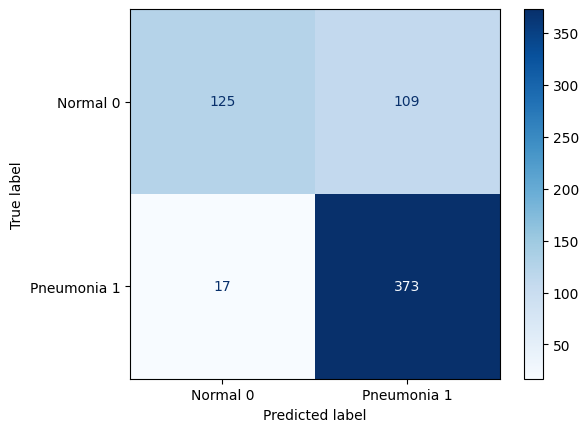

In [53]:
# Evaluate the reg_model to see the results with the test data. Calculate and plot the confusion matrix to see a visualization of the results.
reg_model.evaluate(test_img_final, test_label_final)

y_pred_binary = (reg_model.predict(test_img_final) > 0.5).astype(int)
cnf_matrix = confusion_matrix(test_label_final, y_pred_binary)

display_labels = ['Normal 0', 'Pneumonia 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)

# **Evaluation**

In [54]:
final_model = reg_model

In [55]:
#Set our final model and evaluate on the valid data.
final_model.evaluate(valid_img_final, valid_label_final)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.4079 - recall: 1.0000


[0.40785783529281616, 1.0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


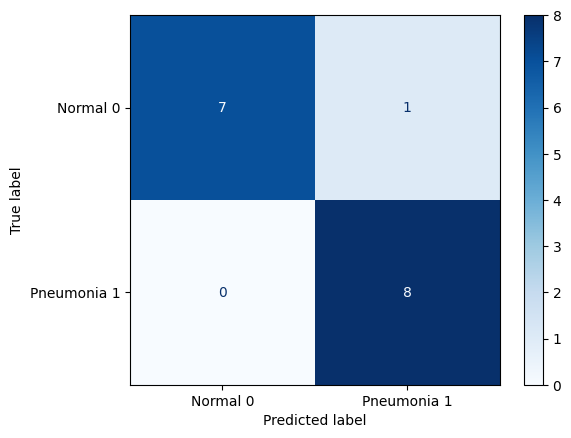

In [56]:
#Calculate and plot the confusion matrix to see a visualization of the results.
y_pred_binary = (final_model.predict(valid_img_final) > 0.5).astype(int)
cnf_matrix = confusion_matrix(valid_label_final, y_pred_binary)

display_labels = ['Normal 0', 'Pneumonia 1']

disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=display_labels)
disp.plot(cmap=plt.cm.Blues)

In [46]:
#Creat path for an image of pneumonia to be used with LIME.
img_path_pneumonia = '/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'

In [47]:
#Creat path for an image of normal to be used with LIME.
img_path_normal = '/content/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'

In [48]:
#Currently, our final model was trained on a flattened image dataset (None, 49152) but LIME requires images in their its original shape (128x128x3 in this case).
#So I need to reshape my images to not throw an error when running LIME explainer.
def predict_fn(images):
  '''
  Takes in the image (images) and reshapes them. Then uses our model to make their predictions so they can be passed into LIME explainer.
  '''
  reshaped_images = images.reshape(images.shape[0], -1)
  predictions = final_model.predict(reshaped_images)
  return predictions

In [49]:
#Creating a function that can be reused for a normal image and a pnuemonia image. It will take in the image and shape/standardize it appropriately so it can be passed
#into the LIME explainer and our final model. Then it will output the original image and show the areas where the model focused on when making its decisions.
def show_hot_spots(imge):
  '''
  Takes in the image (imge) and reshapes/stadardizes it. Then creates an instance of LimeImageExplainer. Uses the explainer with the model and image to create
  our predicitions. Finally, takes the results of the explainer and creates a visualization of the results.
  '''
#Load and preprocess the image
  img = image.load_img(imge, target_size=(128, 128))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0

#Create a LimeImageExplainer
  explainer = lime_image.LimeImageExplainer()

#Explain the prediction
  explanation = explainer.explain_instance(x[0],
                                        predict_fn,
                                        top_labels=2,
                                        hide_color=0,
                                        num_samples=1000)

#Finally, takes in the results from explainer and shows the positive and negative cases for when it made its decision.
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
  plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
  plt.title('LIME Explanation')

  return plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

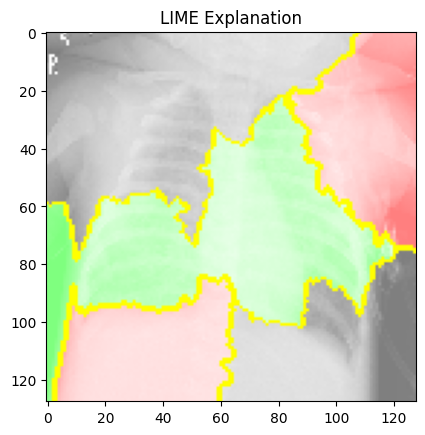

In [50]:
#Apply the function with an image where someone had pneumonia.
show_hot_spots(img_path_pneumonia)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

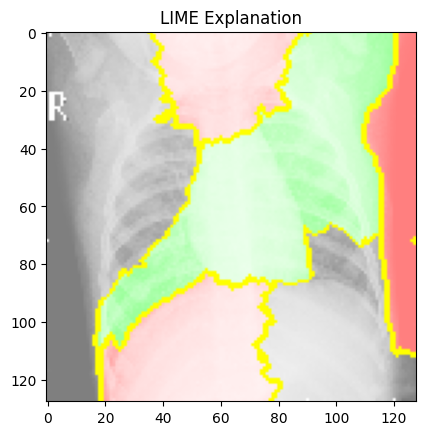

In [51]:
#Apply the function with an image where someone was normal.
show_hot_spots(img_path_normal)